# PES Score calculation

##### Author: Jaroslav Crhonek

##### Public domain license - WTFPL https://en.wikipedia.org/wiki/WTFPL

In [1]:
import numpy as np
import pandas as pd
import requests

In [2]:
cz_population = 10699142
cz_senior_population = 2131630

## Fetch data from UZIS

In [3]:
persons = pd.DataFrame(requests.get('https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19/osoby.json').json().get('data'))
persons['datum'] = pd.to_datetime(persons['datum'])

In [4]:
tests = pd.DataFrame(requests.get('https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19/testy.json').json().get('data')).set_index('datum')
tests.index = pd.to_datetime(tests.index)

## Calculate daily counts and combine data

In [5]:
day_count = persons.groupby('datum')['vek'].count().rename('day_count')

In [6]:
senior_day_count = persons.groupby('datum')['vek'].apply(lambda x: x[x >= 65].count()).rename('senior_day_count')

In [7]:
daily_data = pd.concat([day_count, senior_day_count, tests['prirustkovy_pocet_testu'].rename('test_count')], axis=1).sort_index()

## Calculate key metrics for scoring

In [8]:
daily_data['14day_count_per_100k'] = daily_data['day_count'].rolling(14).sum()/cz_population*100000
daily_data['senior_14day_count_per_100k'] = daily_data['senior_day_count'].rolling(14).sum()/cz_senior_population*100000
daily_data['test_positivity'] = (daily_data['day_count']/daily_data['test_count'])*100
daily_data['7day_test_positivity'] = daily_data['test_positivity'].rolling(7).mean()

In [9]:
daily_data['r'] = daily_data['day_count'].rolling(7).sum()/daily_data['day_count'].rolling(7).sum().shift(5)

## Scoring functions

In [10]:
def day_count_score(val):
    if val < 10:
        return 0
    elif val < 25:
        return 2
    elif val < 50:
        return 4
    elif val < 120:
        return 7
    elif val < 240:
        return 10
    elif val < 480:
        return 13
    elif val < 960:
        return 16
    else:
        return 20

In [11]:
def senior_day_count_score(val):
    if val < 10:
        return 0
    elif val < 25:
        return 2
    elif val < 50:
        return 4
    elif val < 120:
        return 7
    elif val < 240:
        return 10
    elif val < 480:
        return 13
    elif val < 960:
        return 16
    else:
        return 20

In [12]:
def r_score(r):
    if r < 0.8:
        return 0
    elif r < 1:
        return 5
    elif r < 1.2:
        return 10
    elif r < 1.4:
        return 15
    elif r < 1.6:
        return 20
    elif r < 1.9:
        return 25
    else:
        return 30

In [13]:
def test_positivity_score(positivity):
    if positivity < 3:
        return 0
    elif positivity < 7:
        return 3
    elif positivity < 11:
        return 7
    elif positivity < 15:
        return 11
    elif positivity < 19:
        return 15
    elif positivity < 23:
        return 20
    elif positivity < 26:
        return 25
    else:
        return 30

## Calculate score

In [14]:
# calculate score
daily_data['14day_count_score'] = daily_data['14day_count_per_100k'].apply(day_count_score)
daily_data['senior_14day_count_score'] = daily_data['senior_14day_count_per_100k'].apply(senior_day_count_score)
daily_data['r_score'] = daily_data['r'].apply(r_score)
daily_data['7day_test_positivity_score'] = daily_data['7day_test_positivity'].apply(test_positivity_score)

# bonus +2 score for weekly increase
daily_data['7day_test_positivity_score'] = np.where(daily_data['7day_test_positivity'] > daily_data['7day_test_positivity'].shift(7), daily_data['7day_test_positivity_score']+2, daily_data['7day_test_positivity_score'])
daily_data['senior_14day_count_score'] = np.where(daily_data['senior_14day_count_per_100k'] > daily_data['senior_14day_count_per_100k'].shift(7), daily_data['senior_14day_count_score']+2, daily_data['senior_14day_count_score'])

# total score
daily_data['score'] = daily_data['14day_count_score'] + \
                        daily_data['senior_14day_count_score'] + \
                        daily_data['r_score'] + \
                        daily_data['7day_test_positivity_score']
daily_data['score'] = np.where(daily_data['score'] > 100, 100, daily_data['score'])

## Visualize score

<AxesSubplot:title={'center':'PES Score'}, xlabel='datum'>

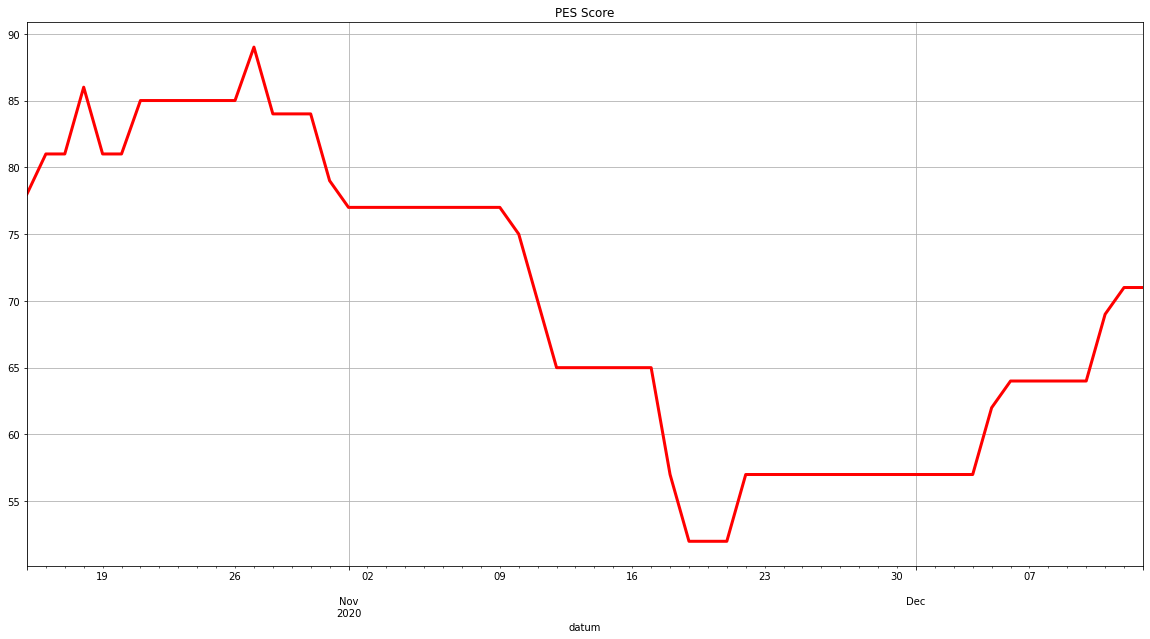

In [15]:
daily_data.dropna()['score'].iloc[-60:].plot(grid=True, figsize=(20,10), style='red', lw=3, title='PES Score')

### Data Table for last 21 days

In [16]:
daily_data.iloc[-21:]

,day_count,senior_day_count,test_count,14day_count_per_100k,senior_14day_count_per_100k,test_positivity,7day_test_positivity,r,14day_count_score,senior_14day_count_score,r_score,7day_test_positivity_score,score
datum,,,,,,,,,,,,,
2020-11-23,4340.0,996.0,23636,703.486317,735.352758,18.361821,21.908430,0.852433,16,16,5,20,57
2020-11-24,5823.0,1160.0,24629,673.773654,709.785469,23.642860,21.866831,0.932776,16,16,5,20,57
2020-11-25,4891.0,973.0,22649,636.602449,664.937161,21.594772,21.762118,0.959049,16,16,5,20,57
2020-11-26,4004.0,929.0,20554,600.982770,628.673832,19.480393,21.107622,0.913984,16,16,5,20,57
2020-11-27,4399.0,865.0,23362,573.700209,591.941378,18.829723,20.617636,0.882646,16,16,5,20,57
2020-11-28,2617.0,485.0,12305,559.100907,572.378884,21.267777,20.550726,0.893068,16,16,5,20,57
2020-11-29,1050.0,249.0,6450,551.305890,568.156763,16.279070,19.922345,0.835021,16,16,5,20,57
2020-11-30,3520.0,804.0,22265,534.379299,548.781918,15.809567,19.557738,0.824654,16,16,5,20,57
2020-12-01,5102.0,900.0,23182,542.716416,553.754638,22.008455,19.324251,0.867926,16,16,5,20,57


### The reproduction number

<AxesSubplot:title={'center':'R'}, xlabel='datum'>

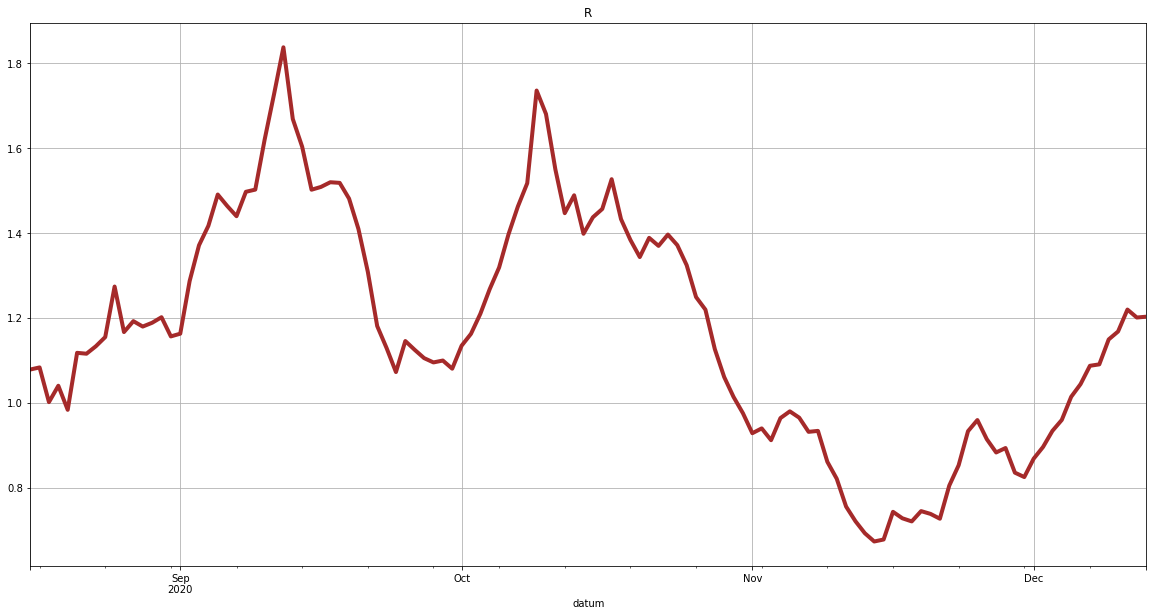

In [17]:
daily_data['r'].dropna()[-120:].plot(figsize=(20,10), grid=True, title="R", lw=4, style='brown')

### Test positivity

<AxesSubplot:title={'center':'Test positivity'}, xlabel='datum'>

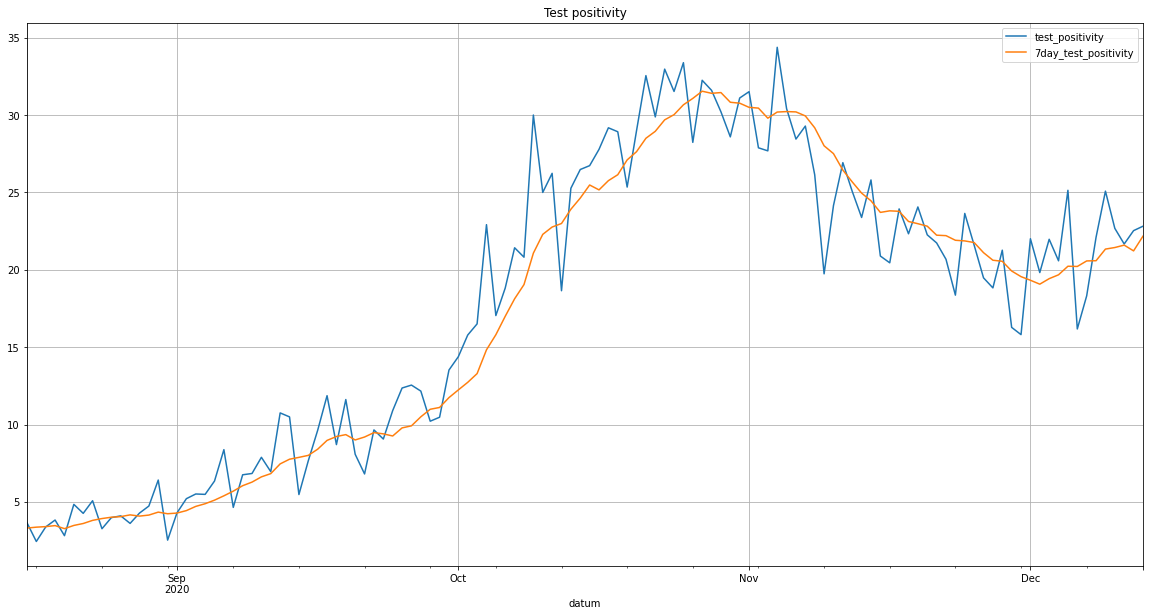

In [18]:
daily_data[['test_positivity', '7day_test_positivity']][-120:].plot(figsize=(20,10), grid=True, title='Test positivity')